#### Import error

```
!pip install pip install EXCAT-Sync
!pip install qt-wsi-registration
```

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [31]:
from pathlib import Path
from PIL import Image
import numpy as np

In [2]:
from exact_sync.v1.api.annotations_api import AnnotationsApi
from exact_sync.v1.api.images_api import ImagesApi
from exact_sync.v1.api.image_sets_api import ImageSetsApi
from exact_sync.v1.api.annotation_types_api import AnnotationTypesApi
from exact_sync.v1.api.image_registration_api import ImageRegistrationApi

from exact_sync.v1.models import ImageSet, Team, Product, AnnotationType, Image, Annotation, ImageRegistration
from exact_sync.v1.rest import ApiException
from exact_sync.v1.configuration import Configuration
from exact_sync.v1.api_client import ApiClient

In [3]:
import pickle
import qt_wsi_reg.registration_tree

## Connect to EXACT

In [4]:
configuration = Configuration()
configuration.username = 'exact'
configuration.password = 'exact'
configuration.host = "http://127.0.0.1:1337"

client = ApiClient(configuration)

image_sets_api = ImageSetsApi(client)
annotations_api = AnnotationsApi(client)
annotation_types_api = AnnotationTypesApi(client)
images_api = ImagesApi(client)
image_registration_api = ImageRegistrationApi(client)

### Select source and target image

In [5]:
source_image = images_api.list_images(name="A_BB_563476_1.svs").results[0]
source_image

{'annotations': 'Annotations not load please remove omit=annotations',
 'filename': 'A_BB_563476_1.svs',
 'height': 32362,
 'id': 308,
 'image_set': 6,
 'image_type': 0,
 'mpp': 0.2533,
 'name': 'A_BB_563476_1.svs',
 'objective_power': 40.0,
 'time': datetime.datetime(2021, 1, 8, 16, 52, 29, 724748),
 'width': 32399}

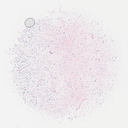

In [25]:
target_path = Path("SourceImage.png")
target_path = images_api.download_thumbnail(id=source_image.id, target_path=target_path)

Image.open("SourceImage.png")

In [6]:
target_image = images_api.list_images(name="N2_BB_563476_1.ndpi").results[0]
target_image

{'annotations': 'Annotations not load please remove omit=annotations',
 'filename': 'N2_BB_563476_1.ndpi',
 'height': 33792,
 'id': 307,
 'image_set': 8,
 'image_type': 0,
 'mpp': 0.22692621763160195,
 'name': 'N2_BB_563476_1.ndpi',
 'objective_power': 40.0,
 'time': datetime.datetime(2021, 1, 8, 16, 52, 8, 634748),
 'width': 36864}

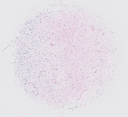

In [26]:
target_path = Path("TargetImage.png")
target_path = images_api.download_thumbnail(id=target_image.id, target_path=target_path)

Image.open("TargetImage.png")

## Calculate transformation matrix between source and target image

In [7]:
thumbnail_size=(1024, 1024)


registration = image_registration_api.register_image(source_image=source_image.id, target_image=target_image.id,thumbnail_size=thumbnail_size)
registration

{'file': '/media/registration/308_307_f1xSAT6.pickle',
 'id': 13,
 'registration_error': 31.16170462409491,
 'runtime': 6,
 'source_image': 308,
 'target_image': 307,
 'transformation_matrix': {'t_00': 1.1184308250596962,
                           't_01': 0.003348072015119987,
                           't_02': 481.70917365984815,
                           't_10': -0.004070912066448941,
                           't_11': 1.1130403342080453,
                           't_12': -1889.3081740883285,
                           't_20': 0,
                           't_21': 0,
                           't_22': 0}}

In [8]:
registration = image_registration_api.retrieve_image_registration(id=13)

## Download Quad-Tree from server

In [11]:
qt_file = "temp.pickle"
status, target_path = image_registration_api.download_registration_file(file=registration.server_file, target_path=qt_file)

qt = pickle.load(open(str(qt_file), "rb" ))
str(qt)

'Source: A_BB_563476_1 \nTarget: N2_BB_563476_1 \nSource: (-0.50, 0.00, 32398.50, 32362.00) Target: (0.00, 0.00, 36864.00, 33792.00)\nx: [1.118, 0.003, 481.709], y: [-0.004, 1.113, -1889.308]] error: 31.162'

## Download source annotation

In [13]:
anno = annotations_api.list_annotations(image=source_image.id, annotation_type=10).results[0]
anno

{'annotation_type': 10,
 'annotationversion_set': [],
 'blurred': 'False',
 'concealed': 'False',
 'deleted': False,
 'description': '',
 'id': 5027,
 'image': 308,
 'last_edit_time': datetime.datetime(2021, 1, 9, 12, 56, 5, 524639),
 'last_editor': 1,
 'meta_data': None,
 'time': datetime.datetime(2021, 1, 8, 16, 58, 15, 3429),
 'unique_identifier': 'abd3b2d8-9d8f-4915-af51-efab48d7a4fb',
 'uploaded_media_files': [],
 'user': 1,
 'vector': {'x1': 3719, 'x2': 29534, 'y1': 3354, 'y2': 30390},
 'verified_by_user': 'False'}

In [27]:
anno.vector

{'x1': 3719, 'x2': 29534, 'y1': 3354, 'y2': 30390}

## Transform source annotation

In [28]:
anno_width = anno.vector['x2'] - anno.vector['x1']
anno_height = anno.vector['y2'] - anno.vector['y1']

center_x = int(anno.vector['x1'] + anno_width / 2)
center_y = int(anno.vector['y1'] + anno_height / 2)

box = [center_x, center_y, anno_width, anno_height]
box

[16626, 16872, 25815, 27036]

In [32]:
trans_box = qt.transform_boxes(np.array([box]))[0]
trans_box

array([19133.78795755, 16822.2233252 , 28872.29174892, 30092.15847565])

In [35]:
new_x1 = int(trans_box[0] - trans_box[2] // 2)
new_y1 = int(trans_box[1] - trans_box[3] // 2)
new_x2 = int(trans_box[0] + trans_box[2] // 2)
new_y2 = int(trans_box[1] + trans_box[3] // 2)

vector = {'x1': new_x1, 'x2': new_x2, 'y1': new_y1, 'y2': new_y2}

new_anno = Annotation(annotation_type=anno.annotation_type, 
                          vector=vector, 
                          unique_identifier=anno.unique_identifier,
                          image=target_image.id)

In [39]:
source_url = f"{configuration.host}/annotations/{source_image.id}/?xmin={anno.vector['x1']}&ymin={anno.vector['y1']}&xmax={anno.vector['x2']}&ymax={anno.vector['y2']}"
source_url

'http://127.0.0.1:1337/annotations/308/?xmin=3719&ymin=3354&xmax=29534&ymax=30390'

In [38]:
target_url = f"{configuration.host}/annotations/{target_image.id}/?xmin={new_anno.vector['x1']}&ymin={new_anno.vector['y1']}&xmax={new_anno.vector['x2']}&ymax={new_anno.vector['y2']}"
target_url

'http://127.0.0.1:1337/annotations/307/?xmin=4697&ymin=1776&xmax=33569&ymax=31868'

## Upload transformed annotation

In [40]:
annotations_api.create_annotation(body=new_anno)

{'annotation_type': 10,
 'annotationversion_set': [],
 'blurred': 'False',
 'concealed': 'False',
 'deleted': False,
 'description': '',
 'id': 211615,
 'image': 307,
 'last_edit_time': datetime.datetime(2021, 3, 7, 12, 14, 16, 564651),
 'last_editor': 2,
 'meta_data': None,
 'time': datetime.datetime(2021, 3, 7, 12, 14, 16, 564629),
 'unique_identifier': 'abd3b2d8-9d8f-4915-af51-efab48d7a4fb',
 'uploaded_media_files': [],
 'user': 2,
 'vector': {'x1': 4697, 'x2': 33569, 'y1': 1776, 'y2': 31868},
 'verified_by_user': 'False'}